# RFM Customer Segmentation Project

RFM (Recency, Frequency, and Monetary) analysis is a popular method for customer segmentation that helps businesses understand customer behavior and target them more effectively. It's used primarily to evaluate customer value and predict future purchasing behavior by analyzing three key aspects:

- Recency (days): Measures how recent was each customer's last purchase
- Frequency (invoices): Measures how many purchases the customer has done in the recorded period (in this case 12-month)
- Monetary (sterling): How much money a customer spends in the recorded period (in this case 12-month). Customers who spend more are considered high-value and should be prioritized in retention and upselling strategies.

## Data Dictionary

UCI Online Retail Dataset

This is a transnational data set which contains all the transactions occurring from December 1st 2010 until December 9th 2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. Each row represents the transaction that occurs. It includes the product name, quantity, price, and other columns that represents ID.

Source: http://archive.ics.uci.edu/ml/datasets/Online+Retail (Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.)

In [1]:
import pandas as pd
# Show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)

# Data Description for each column
column_description = pd.DataFrame({
    'Column Name':['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
    ,'Description':[
        'Invoice number.If this code starts with letter "c", it indicates a cancellation.'
        ,'Product (item) code'
        ,'Product (item) name.'
        ,'The quantities of each product (item) per transaction.'
        ,'Invice Date and time'
        ,'Unit price'
        ,'Customer number'
        ,'Country name'
    ]
    ,'Data Type':[
        'Nominal, a 6-digit integral number uniquely assigned to each transaction'
        ,'Nominal, a 5-digit integral number uniquely assigned to each distinct product'
        ,'Nominal'
        ,'Numeric'
        ,'Numeric, the day and time when each transaction was generated'
        ,'Numeric, Product price per unit in sterling'
        ,'Nominal, a 5-digit integral number uniquely assigned to each customer'
        ,'Nominal, the name of the country where each customer reside'
    ]
})
column_description

,Column Name,Description,Data Type
0,InvoiceNo,"Invoice number.If this code starts with letter ""c"", it indicates a cancellation.","Nominal, a 6-digit integral number uniquely assigned to each transaction"
1,StockCode,Product (item) code,"Nominal, a 5-digit integral number uniquely assigned to each distinct product"
2,Description,Product (item) name.,Nominal
3,Quantity,The quantities of each product (item) per transaction.,Numeric
4,InvoiceDate,Invice Date and time,"Numeric, the day and time when each transaction was generated"
5,UnitPrice,Unit price,"Numeric, Product price per unit in sterling"
6,CustomerID,Customer number,"Nominal, a 5-digit integral number uniquely assigned to each customer"
7,Country,Country name,"Nominal, the name of the country where each customer reside"


# I. Data Validation

This process involves checking for errors, inconsistencies, and missing values in the data to ensures the accuracy, quality, and integrity of the data by checking duplicates, missing data, structural errors, outliers of the dataset.

Data Validation is necessary to produce clean and reliable data that is ready for analysis or further processing.

## 1.1. Import the necessary libraries

In [64]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import plotly.graph_objects as go 

import datetime as dt # datetime manipulation
from scipy.stats import skew # calculating skewness

# display full outputs in Jupyter Notebook, not only the last command's output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1.2. Load the dataset

In [3]:
# read the data
ecommerce_data = pd.read_csv(r'data\\E-Commerce Data.csv', encoding='ISO-8859-1')
ecommerce_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 1.3. Removing Duplicates

In [4]:
print(f'Number of duplicated rows: {ecommerce_data.duplicated().sum()}')

Number of duplicated rows: 5268


In [5]:
# duplicate sample row
ecommerce_data[ecommerce_data.duplicated()].iloc[0]

InvoiceNo                           536409
StockCode                            21866
Description    UNION JACK FLAG LUGGAGE TAG
Quantity                                 1
InvoiceDate                12/1/2010 11:45
UnitPrice                             1.25
CustomerID                         17908.0
Country                     United Kingdom
Name: 517, dtype: object

In [6]:
ecommerce_data[(ecommerce_data['InvoiceNo'] == '536409') & (ecommerce_data['StockCode'] == '21866')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom


Those duplicated records can skew our analysis. Therefore, let's drop these records.

In [7]:
ecommerce_data.drop_duplicates(inplace=True)
print(f'Number of duplicated rows: {ecommerce_data.duplicated().sum()}')

Number of duplicated rows: 0


## 1.4. Handling Missing Data

In [8]:
missing_data = ecommerce_data.isnull().sum().to_frame().rename(columns={0: 'total'})
missing_data['percent'] = (missing_data['total'] / ecommerce_data.shape[0]) * 100   
missing_data

,total,percent
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,1454,0.270945
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135037,25.163377
Country,0,0.000000


CustomerID has the highest null value taking up to 25% of total records, we can try:
1. Drop all null value rows
2. Try to find ways to fill those Nan values

With option 2 in mind, I have a theory to fill in values. For example, InvoiceNo A has CustomerID A and Customer null, I can replace these NaN CustomerID with existing CustomerID A since it's just missing input error. 

If option 2 failed, I will do option 1 which is dropping all null value rows for further analysis.

In [9]:
null_df = ecommerce_data[ecommerce_data['CustomerID'].isnull()]
null_df.reset_index(drop=True, inplace=True)
null_df.shape
null_df.head()

(135037, 8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
2,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
3,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
4,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [10]:
not_null_df=ecommerce_data[ecommerce_data['CustomerID'].isnull() == False]
not_null_df.reset_index(drop=True, inplace=True)
not_null_df.shape
not_null_df.head()

(401604, 8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [11]:
##### Find intersection between 2 dataframes with same InvoiceNo values
null_df[null_df['InvoiceNo'].isin(not_null_df['InvoiceNo'].unique())]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


There is no repeated Invoice Number between the not null and the null customerID data. Therefore, we can not perform any imputation here, this leaves us no choice but to remove these null records.

In [12]:
# Drop rows with missing CustomerID
ecommerce_data = ecommerce_data[~ecommerce_data['CustomerID'].isnull()]
ecommerce_data.reset_index(drop=True, inplace=True)
ecommerce_data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [13]:
# Check missing values again
missing_data = ecommerce_data.isnull().sum().to_frame().rename(columns={0: 'total'})
missing_data['percent'] = (missing_data['total'] / ecommerce_data.shape[0]) * 100   
missing_data

,total,percent
InvoiceNo,0,0.0
StockCode,0,0.0
Description,0,0.0
Quantity,0,0.0
InvoiceDate,0,0.0
UnitPrice,0,0.0
CustomerID,0,0.0
Country,0,0.0


## 1.5. Datetime Datatype Conversion

According to the Description of the Dataset, InvoiceDate is the only column containing datetime datatype and is extremely crucial for generating Recency, Frequency feature of RFM Analysis.

In [14]:
import datetime # datetime manipulation

# validate date format
def validate_datetime(d):
    try:
        datetime.datetime.strptime('4/21/2011 19:05', '%m/%d/%Y %H:%M')
        return True
    except ValueError:
        return False
    
ecommerce_data[~ecommerce_data['InvoiceDate'].apply(lambda x: validate_datetime(x))]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


So our datetime data is validated with '%m/%d/%Y %H:%M' format, let's convert them from object to datetime

In [15]:
# datetime conversion
ecommerce_data['InvoiceDate'] = pd.to_datetime(ecommerce_data['InvoiceDate'],format='%m/%d/%Y %H:%M')
ecommerce_data['InvoiceDate'].describe()

count                           401604
mean     2011-07-10 12:08:23.848567552
min                2010-12-01 08:26:00
25%                2011-04-06 15:02:00
50%                2011-07-29 15:40:00
75%                2011-10-20 11:58:30
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

## 1.6. Object Datatype Conversion

Follow the description of dataset, there are 5 Columns containing Nominal datatype:
- InvoiceNo
- StockCode
- Description
- CustomerID
- Country

In [16]:
# Check the number of categorical columns
print(f'There are currently only {ecommerce_data.select_dtypes(include="object").columns.size} Nominal columns\n')

# Check the unique values of each categorical column
for cate_col in ecommerce_data.select_dtypes(include='object').columns:
    print(f'{cate_col}: {ecommerce_data[cate_col].nunique()} unique values')

There are currently only 4 Nominal columns

InvoiceNo: 22190 unique values
StockCode: 3684 unique values
Description: 3896 unique values
Country: 37 unique values


Let's convert CustomerID into Nominal type too.

In [17]:
ecommerce_data['CustomerID'] = ecommerce_data['CustomerID'].astype(int).astype(str)
# Check the number of categorical columns
print(f'There are currently {ecommerce_data.select_dtypes(include="object").columns.size} Nominal columns\n')

# Check the unique values of each categorical column
for cate_col in ecommerce_data.select_dtypes(include='object').columns:
    print(f'{cate_col}: {ecommerce_data[cate_col].nunique()} unique values')

There are currently 5 Nominal columns

InvoiceNo: 22190 unique values
StockCode: 3684 unique values
Description: 3896 unique values
CustomerID: 4372 unique values
Country: 37 unique values


## 1.7. Checking Outliers

In [18]:
ecommerce_data.select_dtypes([int,float]).columns

Index(['Quantity', 'UnitPrice'], dtype='object')

<Figure size 900x600 with 0 Axes>

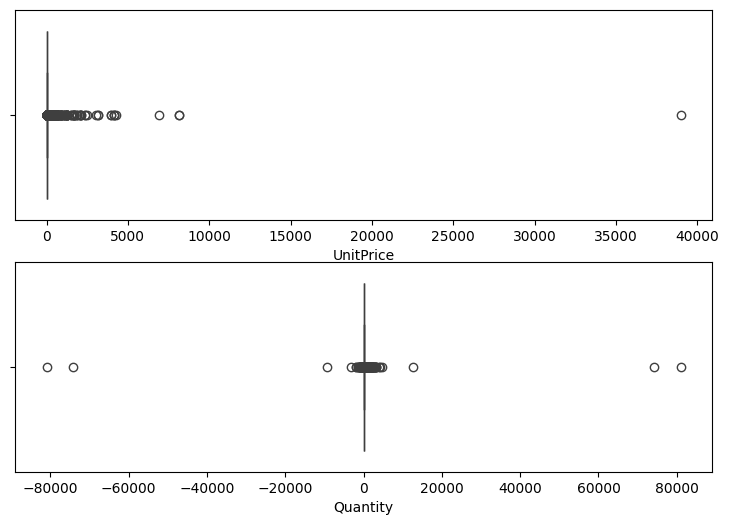

In [19]:
import matplotlib.gridspec as gridspec # subplots

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 1)

# Create a figure
plt.figure(figsize=(9,6))

# add axes_1
ax1 = plt.subplot(gs[0, 0]) 
ax1 = sns.boxplot(
    data=ecommerce_data.UnitPrice
    ,orient='h'
)

# add axes_2
ax2 = plt.subplot(gs[1, 0]) 
ax2 = sns.boxplot(
    data=ecommerce_data.Quantity
    ,orient='h'
)

plt.show()

As box plot shown above, there a number of records with negative values of quantity. These negative values could be indicates a cancellation, discount, which from RFM Analysis aspect, we may need some transaction such as discount to reflect the actual customer behaviour. So these negative values could be true outliers, not incorrect, structural errors caused by data entry, processing stages.

# II. Data Filtering

This process involves removing or excluding data that does not meet certain conditions or criteria. Includes filtering based on values, ranges, or conditions (e.g., removing outliers, selecting specific time periods) with the purpose to select only a subset of data based on specific criteria to focus on relevant information in order to produce a refined dataset that contains only the relevant information needed for analysis, in this case, for the RFM analysis.

## 2.1. Non-Product Description

In [20]:
# Check lowercase Description
ecommerce_data[ecommerce_data['Description'].str.contains('[a-z]')]['Description'].value_counts()

Description
Manual                                 460
BAG 125g SWIRLY MARBLES                252
3 TRADITIONAl BISCUIT CUTTERS  SET     207
BAG 250g SWIRLY MARBLES                201
POLYESTER FILLER PAD 40x40cm           185
POLYESTER FILLER PAD 45x45cm           135
BAG 500g SWIRLY MARBLES                115
Next Day Carriage                       80
Discount                                77
FRENCH BLUE METAL DOOR SIGN No          75
POLYESTER FILLER PAD 45x30cm            37
POLYESTER FILLER PAD 30CMx30CM          26
ESSENTIAL BALM 3.5g TIN IN ENVELOPE     18
CRUK Commission                         16
NUMBER TILE COTTAGE GARDEN No           12
Bank Charges                            12
FOLK ART GREETING CARD,pack/12          10
NUMBER TILE VINTAGE FONT No              7
THE KING GIFT BAG 25x24x12cm             7
POLYESTER FILLER PAD 65CMx65CM           5
FLOWERS HANDBAG blue and orange          3
High Resolution Image                    3
POLYESTER FILLER PAD 60x40cm             1

Description such as Manual, Bank Charges, etc is not product, therefore, let's gather these values into a non product list.

In [21]:
not_products = ['Next Day Carriage', 
                'Discount', 
                'CRUK Commission', 
                'Bank Charges', 
                'Manual']

In [22]:
# Check short Description
def short_description(desc):
    return len(desc.split()) < 3
ecommerce_data[
    (ecommerce_data['Description'].apply(lambda x: short_description(x))) &
    (~ecommerce_data['Description'].isin(not_products))
]['Description'].unique()

array(['POSTAGE', 'CHOCOLATE CALCULATOR', 'CHILLI LIGHTS', 'PHOTO CUBE',
       'RETROSPOT LAMP', 'PICTURE DOMINOES', 'DOORMAT TOPIARY',
       'DOORMAT HEARTS', 'WRAP COWBOYS  ', 'FLOWERS  STICKERS',
       'OWL DOORSTOP', 'WICKER STAR ', 'CHRYSANTHEMUM NOTEBOOK',
       'BUTTON BOX ', 'POLKADOT PEN', 'GRAND CHOCOLATECANDLE', 'CARRIAGE',
       'DOORMAT AIRMAIL ', 'NEWSPAPER STAND', 'BINGO SET',
       'CHRYSANTHEMUM SKETCHBOOK ', 'SKULLS  STICKERS', 'GLAMOROUS  MUG',
       'SPACE FROG', 'SPACE OWL', 'DECOUPAGE,GREETING CARD,',
       'DOGGY RUBBER', 'SKULLS TAPE', 'HEARTS  STICKERS', 'PARTY BUNTING',
       'POTTERING MUG', 'SANDALWOOD FAN', 'SOMBRERO ', 'ANIMAL STICKERS',
       'RAIN PONCHO ', 'MIRROR CORNICE', 'CARNIVAL BRACELET',
       'HEART CALCULATOR', 'CHRYSANTHEMUM  JOURNAL',
       'BUTTERFLIES STICKERS', 'TUMBLER, BAROQUE', 'PLASMATRONIC LAMP',
       'DAISY JOURNAL ', 'SWEETIES  STICKERS', 'DAISY NOTEBOOK ',
       'GOLD WASHBAG', 'WOODLAND  STICKERS', 'DAISY SKETCHBOOK

'POSTAGE', 'DOTCOM POSTAGE' and 'CARRIAGE' are not products. So I will have them appended to the not_products list

In [23]:
not_products.append('POSTAGE')
not_products.append('CARRIAGE')
not_products.append('DOTCOM POSTAGE')
not_products

['Next Day Carriage',
 'Discount',
 'CRUK Commission',
 'Bank Charges',
 'Manual',
 'POSTAGE',
 'CARRIAGE',
 'DOTCOM POSTAGE']

Let's review records contain these non-product description

In [24]:
for not_product in not_products:    
    ecommerce_data[ecommerce_data['Description'] == not_product].sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
196392,561115,23444,Next Day Carriage,1,2011-07-25 12:12:00,15.0,17675,United Kingdom
390631,580599,23444,Next Day Carriage,1,2011-12-05 11:11:00,15.0,12925,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
125818,C552423,D,Discount,-1,2011-05-09 12:44:00,11.84,14527,United Kingdom
244943,C566613,D,Discount,-1,2011-09-13 17:17:00,15.00,16029,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
228470,C564763,CRUK,CRUK Commission,-1,2011-08-30 10:49:00,1.60,14096,United Kingdom
271880,C569245,CRUK,CRUK Commission,-1,2011-10-03 09:57:00,361.59,14096,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
262732,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,0.001,13405,United Kingdom
300216,571900,BANK CHARGES,Bank Charges,1,2011-10-19 14:26:00,15.000,13263,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
56335,C543835,M,Manual,-8,2011-02-14 10:40:00,1.95,12963,United Kingdom
98259,C548830,M,Manual,-1,2011-04-04 13:08:00,239.30,12744,Singapore


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
89230,547715,POST,POSTAGE,2,2011-03-25 08:50:00,18.0,12520,Germany
146016,554985,POST,POSTAGE,4,2011-05-29 12:26:00,18.0,12426,Germany


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
144273,554770,C2,CARRIAGE,1,2011-05-26 11:40:00,50.0,14911,EIRE
227001,564654,C2,CARRIAGE,1,2011-08-26 14:29:00,50.0,14911,EIRE


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
393592,580727,DOT,DOTCOM POSTAGE,1,2011-12-05 17:17:00,1599.26,14096,United Kingdom
239480,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096,United Kingdom


From the data above and through online research, I came to conclusion that: 
- POSTAGE/DOTCOM POSTAGE/Next Day Carriage: The amount spent by the user on postages.
- Discount: This explains the discount provided for a product.
- CRUK Commission: An initiative to pay some part of the sales to the Cancer Research UK (CRUK).
- Bank Charges: A default fee (about 15 sterling) that customers pay every time they use a bank service as payment method for each purchase. This fee does not directly affect sales.
- Manual: Since there is no proper definition we can think of this as manual service provided for the purchase of an item.


Except for Discount, all the other categories do not directly affect the sales. Hence, we can remove those from the data.

In [25]:
not_products.remove('Discount')

# Drop rows with not products
ecommerce_data = ecommerce_data[~ecommerce_data['Description'].isin(not_products)]

# validate the result
ecommerce_data['Description'].isin(not_products).sum()

0

In [26]:
ecommerce_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399690 entries, 0 to 401603
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    399690 non-null  object        
 1   StockCode    399690 non-null  object        
 2   Description  399690 non-null  object        
 3   Quantity     399690 non-null  int64         
 4   InvoiceDate  399690 non-null  datetime64[ns]
 5   UnitPrice    399690 non-null  float64       
 6   CustomerID   399690 non-null  object        
 7   Country      399690 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.4+ MB


## 2.2. Cancelled Transactions
As the data description, invoiceNo starting with 'C' are cancelled transactions. Let's check if they are directly affected to the sales or not.

In [27]:
condition = (ecommerce_data['InvoiceNo'].str.contains('C')) & (~ecommerce_data['Description'].str.contains('Discount'))
ecommerce_data[condition].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
915,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897,United Kingdom
1404,C536543,22632,HAND WARMER RED RETROSPOT,-1,2010-12-01 14:30:00,2.10,17841,United Kingdom


(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 8.502e+03]),
 array([-8.09950e+04, -7.28956e+04, -6.47962e+04, -5.66968e+04,
        -4.85974e+04, -4.04980e+04, -3.23986e+04, -2.42992e+04,
        -1.61998e+04, -8.10040e+03, -1.00000e+00]),
 <BarContainer object of 10 artists>)

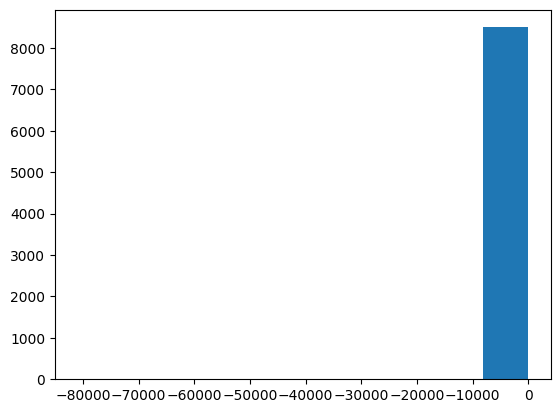

In [28]:
plt.hist(ecommerce_data[condition]['Quantity'])

In [29]:
ecommerce_data[condition]['Description'].value_counts().head(10)

Description
REGENCY CAKESTAND 3 TIER              180
JAM MAKING SET WITH JARS               86
SET OF 3 CAKE TINS PANTRY DESIGN       72
STRAWBERRY CERAMIC TRINKET BOX         54
ROSES REGENCY TEACUP AND SAUCER        53
RECIPE BOX PANTRY YELLOW DESIGN        47
JUMBO BAG RED RETROSPOT                44
WOOD 2 DRAWER CABINET WHITE FINISH     42
WHITE HANGING HEART T-LIGHT HOLDER     42
LUNCH BAG RED RETROSPOT                42
Name: count, dtype: int64

In [30]:
ecommerce_data[ecommerce_data['CustomerID']=='17548'].sort_values(by='InvoiceDate').head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom


Cancelled Transactions are refunded transactions for the customers after they cancelled their orders, this data is directly affecting the sales only when it had a successful recorded order beforehand. (For example: on 2010-12-01, there is only the cancelled Invoice, this does not make sense since it lacks it's cancelled order since the data is recorded from 2010-12-01, therefore, it does not accurately represent an aspect of monetary and should be excluded from the calcualation)

In [31]:
# Calculate the Monetary value for each record
ecommerce_data['Monetary'] = ecommerce_data['Quantity'] * ecommerce_data['UnitPrice']
# Create a new column for the date only
ecommerce_data['InvoiceOnlyDate'] = ecommerce_data['InvoiceDate'].apply(lambda x: dt.datetime.date(x))
# pre-processed data
preprocessed_data = ecommerce_data.groupby(['CustomerID','InvoiceOnlyDate']).agg({
    'Monetary': 'sum' # Monetary value: sum of all transactions
    ,'InvoiceNo': 'nunique'
}).reset_index()

cancelled_data = ecommerce_data[(ecommerce_data['InvoiceNo'].str.contains('C'))].groupby(['CustomerID','InvoiceOnlyDate']).agg({
    'InvoiceNo': 'nunique'
}).rename(columns={'InvoiceNo':'CancelledNo'}).reset_index()
preprocessed_data = preprocessed_data.merge(cancelled_data, on=['CustomerID','InvoiceOnlyDate'], how='left').fillna(0)
preprocessed_data['InvoiceNo'] = preprocessed_data['InvoiceNo'] - preprocessed_data['CancelledNo']
preprocessed_data.drop(columns=['CancelledNo'], inplace=True)
preprocessed_data.head()

,CustomerID,InvoiceOnlyDate,Monetary,InvoiceNo
0,12346,2011-01-18,0.00,1.0
1,12347,2010-12-07,711.79,1.0
2,12347,2011-01-26,475.39,1.0
3,12347,2011-04-07,636.25,1.0
4,12347,2011-06-09,382.52,1.0


In [32]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19129 entries, 0 to 19128
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       19129 non-null  object 
 1   InvoiceOnlyDate  19129 non-null  object 
 2   Monetary         19129 non-null  float64
 3   InvoiceNo        19129 non-null  float64
dtypes: float64(2), object(2)
memory usage: 597.9+ KB


In [33]:
# Remove negative and zero Monetary values
first_purchase_indexes = preprocessed_data.groupby('CustomerID')['InvoiceOnlyDate'].idxmin()
first_payment = preprocessed_data.loc[first_purchase_indexes, 'Monetary']
while any(x <= 0 for x in first_payment):
    preprocessed_data.drop(first_payment[first_payment <= 0].index, inplace=True)
    first_purchase_indexes = preprocessed_data.groupby('CustomerID')['InvoiceOnlyDate'].idxmin()
    first_payment = preprocessed_data.loc[first_purchase_indexes, 'Monetary']

In [34]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18980 entries, 1 to 19128
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       18980 non-null  object 
 1   InvoiceOnlyDate  18980 non-null  object 
 2   Monetary         18980 non-null  float64
 3   InvoiceNo        18980 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB


In [35]:
preprocessed_data.head(10)

,CustomerID,InvoiceOnlyDate,Monetary,InvoiceNo
1,12347,2010-12-07,711.79,1.0
2,12347,2011-01-26,475.39,1.0
3,12347,2011-04-07,636.25,1.0
4,12347,2011-06-09,382.52,1.0
5,12347,2011-08-02,584.91,1.0
6,12347,2011-10-31,1294.32,1.0
7,12347,2011-12-07,224.82,1.0
8,12348,2010-12-16,652.80,1.0
9,12348,2011-01-25,187.44,1.0
10,12348,2011-04-05,327.00,1.0


In [36]:
preprocessed_data.CustomerID.nunique()

4332

The data is cleaned and ready to generate the RFM Score

# III. Features Engineering
- **Recency (days)**: Measures how recent was each customer's last purchase
- **Frequency (invoices)**: Measures how many purchases the customer has done in the recorded period (in this case 12-month)
- **Monetary (M)**: How much money a customer spends in the recorded period (in this case 12-month). Customers who spend more are considered high-value and should be prioritized in retention and upselling strategies.

## 3.1. Generating Recency, Frequency, Monetary Features

In [37]:
processed_data = preprocessed_data.groupby('CustomerID').agg({
    'InvoiceOnlyDate': 'max', # Recency: the last transaction date
    'InvoiceNo': 'sum', # Frequency: total number of transactions excluding cancelled ones
    'Monetary': 'sum' # Monetary: sum of all transactions
}).rename(columns={
    'InvoiceOnlyDate': 'Recency'
    ,'InvoiceNo': 'Frequency'
})
processed_data['Frequency'] = processed_data['Frequency'].astype(int)
processed_data['Recency'] = (processed_data['Recency'].max() - processed_data['Recency'])
processed_data['Recency'] = processed_data['Recency'].apply(lambda x: x.days)
processed_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
12352,36,7,1265.41


In [38]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12347 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4332 non-null   int64  
 1   Frequency  4332 non-null   int32  
 2   Monetary   4332 non-null   float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 118.5+ KB


skewness: 1.2603365850994042


<Figure size 900x900 with 0 Axes>

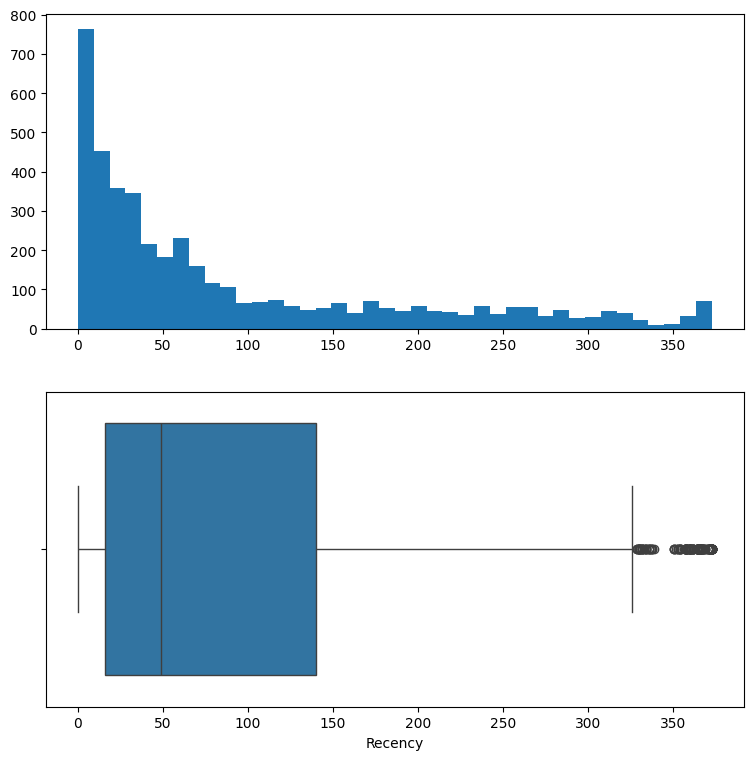

In [39]:
# Create 2x1 sub plots
gs = gridspec.GridSpec(2, 1)

x = processed_data['Recency']

# Calculate the skewness 
print(f'skewness: {skew(x, axis=0, bias=True)}')

# Create a figure
plt.figure(figsize=(9,9))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = plt.hist(x, bins=40)

# add axes_2 row 1, col 0
ax2 = plt.subplot(gs[1, 0]) 
ax2 = sns.boxplot(
    data=x
    ,orient='h'
)

# display plot
plt.show()

skewness: 11.941316632319461


<Figure size 900x900 with 0 Axes>

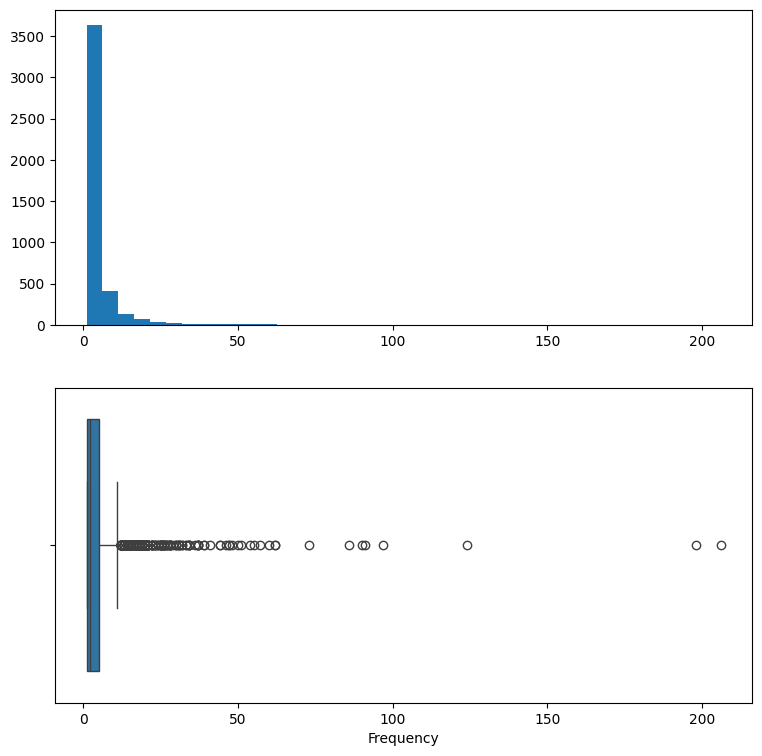

In [40]:
# Create 2x1 sub plots
gs = gridspec.GridSpec(2, 1)

x = processed_data['Frequency']

# Calculate the skewness 
print(f'skewness: {skew(x, axis=0, bias=True)}')

# Create a figure
plt.figure(figsize=(9,9))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = plt.hist(x, bins=40)

# add axes_2 row 1, col 0
ax2 = plt.subplot(gs[1, 0]) 
ax2 = sns.boxplot(
    data=x
    ,orient='h'
)

# display plot
plt.show()

skewness: 21.565161216928185


<Figure size 900x900 with 0 Axes>

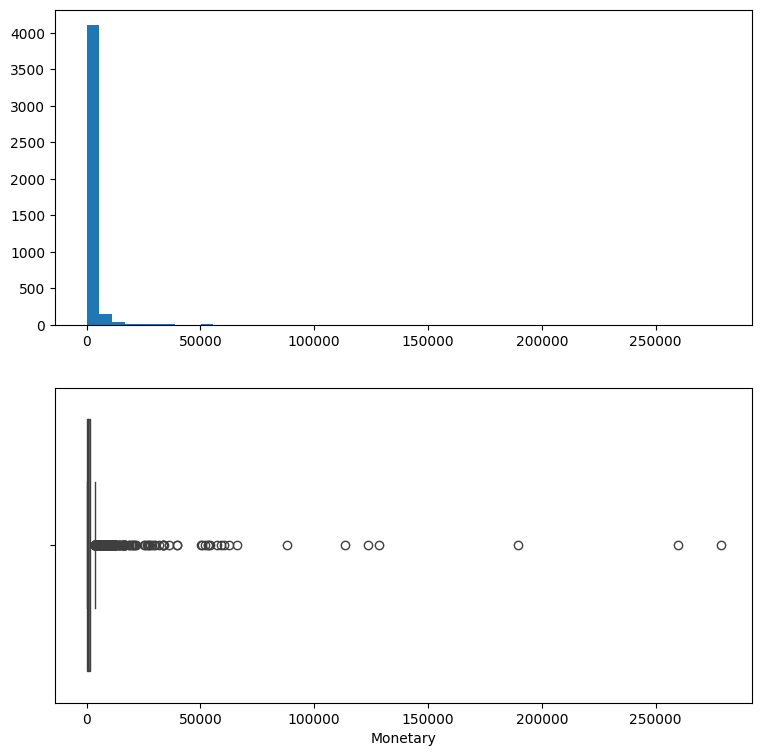

In [41]:
# Create 2x1 sub plots
gs = gridspec.GridSpec(2, 1)

x = processed_data['Monetary']

# Calculate the skewness 
print(f'skewness: {skew(x, axis=0, bias=True)}')

# Create a figure
plt.figure(figsize=(9,9))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = plt.hist(x, bins=50)

# add axes_2 row 1, col 0
ax2 = plt.subplot(gs[1, 0]) 
ax2 = sns.boxplot(
    data=x
    ,orient='h'
)

# display plot
plt.show()

After looking at the extremely skewed distribution (Frequency & Monetary) of each feature, 

I came to an conclusion that we can not use Quantile Cuts method to segment customers based on Recency, Frequency, and Monetary (RFM) metrics since with highly skewed or unevenly distributed, using quantile cuts might lead to unbalanced segments.

Instead, using a method based on percentiles and the IQR can help to create more robust thresholds that focus on the majority of your data, while excluding extreme outliers.

Method Detail: 
- Outlier Detection: The formula Q75 + 1.5 * IQR is a standard rule for detecting outliers. The IQR (Interquartile Range) is the difference between the 25th percentile (Q25) and the 75th percentile (Q75), which measures the spread of the middle 50% of the data. By setting the threshold as Q75 + 1.5 * IQR, I will define a cutoff beyond which values can be considered outliers (values beyond Q75 + 1.5 * IQR are considered unusually high). This method will be applied for Frequency and Monetary because of their extremely high skewness (>10)
- Quantile Cuts: Divide each RFM variable (Recency because of it's low skewness) into several equal-sized groups based on the quantiles of the distribution. Commonly, we use quartiles (4 groups)

## 3.2. Generating Scores of each Feature

### 3.2.1. Frequency Score

In [42]:
# Disable SettingWithCopyWarning
# reference: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  # default='warn'

IQR = processed_data['Frequency'].quantile(0.75) - processed_data['Frequency'].quantile(0.25)
threshold = processed_data['Frequency'].quantile(0.75) + 1.5 * IQR

low_frequency = processed_data[processed_data['Frequency'] <= threshold]
IQR = low_frequency['Frequency'].quantile(0.75) - low_frequency['Frequency'].quantile(0.25)
threshold = low_frequency['Frequency'].quantile(0.75) + 1.5 * IQR

low_frequency_df = low_frequency[low_frequency['Frequency'] <= threshold]
low_frequency_df['FrequencyScore'] = 1

high_frequency = processed_data[processed_data['Frequency'] > threshold]
IQR = high_frequency['Frequency'].quantile(0.75) - high_frequency['Frequency'].quantile(0.25)
threshold = high_frequency['Frequency'].quantile(0.75) + 1.5 * IQR

high_frequency_df = high_frequency[high_frequency['Frequency'] <= threshold]
high_frequency_df['FrequencyScore'] = 2

very_high_frequency = high_frequency[high_frequency['Frequency'] > threshold]
IQR = very_high_frequency['Frequency'].quantile(0.75) - very_high_frequency['Frequency'].quantile(0.25)
threshold = very_high_frequency['Frequency'].quantile(0.75) + 1.5 * IQR

very_high_frequency_df = very_high_frequency[very_high_frequency['Frequency'] <= threshold]
very_high_frequency_df['FrequencyScore'] = 3

very_very_high_frequency_df = very_high_frequency[very_high_frequency['Frequency'] > threshold]
very_very_high_frequency_df['FrequencyScore'] = 4

In [43]:
rfm_frequency = pd.concat([low_frequency_df, high_frequency_df, very_high_frequency_df, very_very_high_frequency_df])
rfm_frequency.head()
rfm_frequency.shape
rfm_frequency['FrequencyScore'].value_counts()

,Recency,Frequency,Monetary,FrequencyScore
CustomerID,,,,
12347,2,7,4310.00,1
12348,75,4,1437.24,1
12349,18,1,1457.55,1
12350,310,1,294.40,1
12352,36,7,1265.41,1


(4332, 4)

FrequencyScore
1    3877
2     419
3      33
4       3
Name: count, dtype: int64

skewness: 1.1602187033391245


<Figure size 1200x300 with 0 Axes>

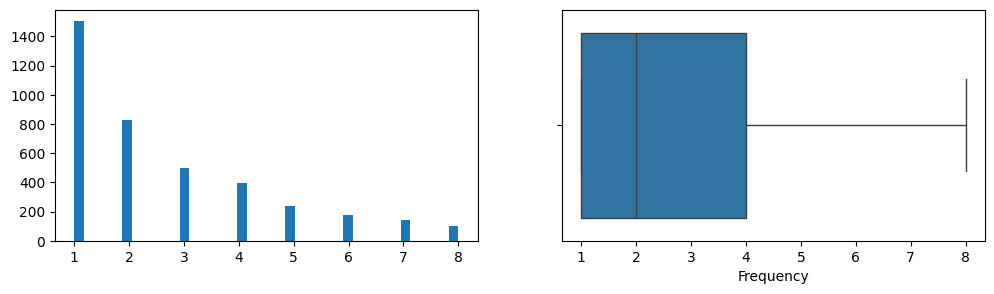

skewness: 1.2935904963529326


<Figure size 1200x300 with 0 Axes>

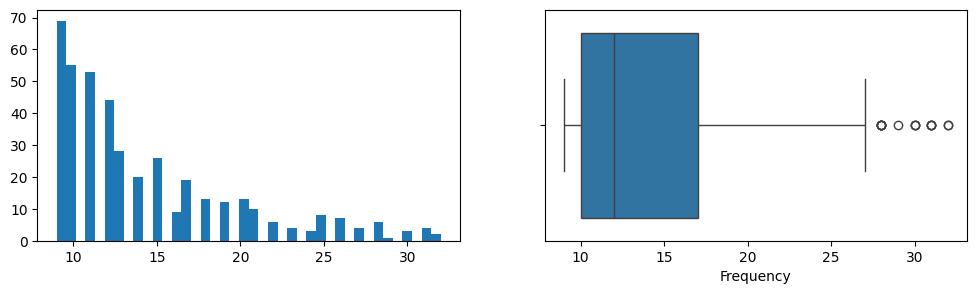

skewness: 1.2494257021322834


<Figure size 1200x300 with 0 Axes>

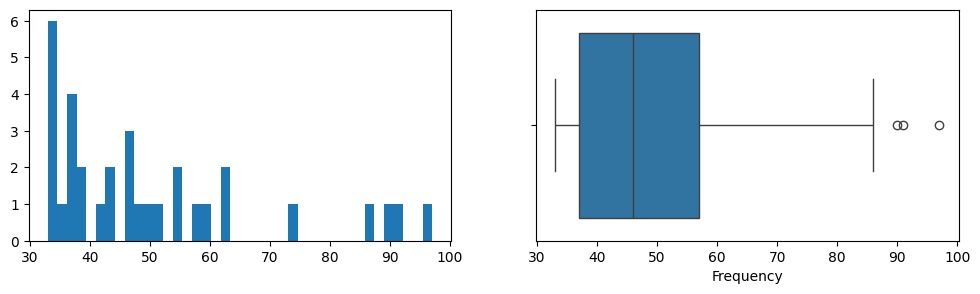

skewness: -0.6822802981483861


<Figure size 1200x300 with 0 Axes>

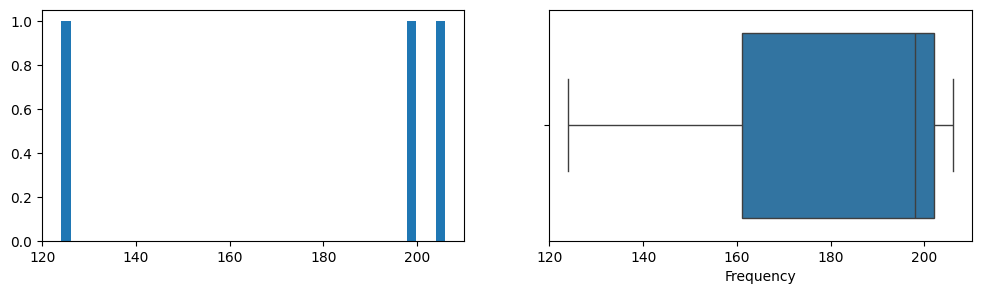

In [44]:


for i in range(1,5):
    x = rfm_frequency[rfm_frequency['FrequencyScore'] == i]['Frequency']

    # Calculate the skewness 
    print(f'skewness: {skew(x, axis=0, bias=True)}')

    # Create 2x1 sub plots
    gs = gridspec.GridSpec(1, 2)

    # Create a figure
    plt.figure(figsize=(12,3))

    # add axes_1 row 0, col 0
    ax1 = plt.subplot(gs[0, 0]) 
    ax1 = plt.hist(x, bins=40)

    # add axes_2 row 0, col 1
    ax2 = plt.subplot(gs[0, 1]) 
    ax2 = sns.boxplot(data=x,orient='h')

    # display plot
    plt.show()

### 3.2.2. Monetary Score

In [45]:
IQR = processed_data['Monetary'].quantile(0.75) - processed_data['Monetary'].quantile(0.25)
threshold = processed_data['Monetary'].quantile(0.75) + 1.5 * IQR

low_monetary = processed_data[processed_data['Monetary'] <= threshold]
IQR = low_monetary['Monetary'].quantile(0.75) - low_monetary['Monetary'].quantile(0.25)
threshold = low_monetary['Monetary'].quantile(0.75) + 1.5 * IQR

low_monetary_df = low_monetary[low_monetary['Monetary'] <= threshold]
low_monetary_df['MonetaryScore'] = 1

high_monetary = processed_data[processed_data['Monetary'] > threshold]
IQR = high_monetary['Monetary'].quantile(0.75) - high_monetary['Monetary'].quantile(0.25)
threshold = high_monetary['Monetary'].quantile(0.75) + 1.5 * IQR

high_monetary_df = high_monetary[high_monetary['Monetary'] <= threshold]
high_monetary_df['MonetaryScore'] = 2

very_high_monetary = high_monetary[high_monetary['Monetary'] > threshold]
IQR = very_high_monetary['Monetary'].quantile(0.75) - very_high_monetary['Monetary'].quantile(0.25)
threshold = very_high_monetary['Monetary'].quantile(0.75) + 1.5 * IQR

very_high_monetary_df = very_high_monetary[very_high_monetary['Monetary'] <= threshold]
very_high_monetary_df['MonetaryScore'] = 3

very_very_high_monetary_df = very_high_monetary[very_high_monetary['Monetary'] > threshold]
very_very_high_monetary_df['MonetaryScore'] = 4

In [46]:
rfm_monetary = pd.concat([low_monetary_df, high_monetary_df, very_high_monetary_df, very_very_high_monetary_df])
rfm_monetary.head()
rfm_monetary.shape
rfm_monetary['MonetaryScore'].value_counts()

,Recency,Frequency,Monetary,MonetaryScore
CustomerID,,,,
12348,75,4,1437.24,1
12349,18,1,1457.55,1
12350,310,1,294.40,1
12352,36,7,1265.41,1
12353,204,1,89.00,1


(4332, 4)

MonetaryScore
1    3695
2     567
3      64
4       6
Name: count, dtype: int64

skewness: 1.1649340969083


<Figure size 1200x300 with 0 Axes>

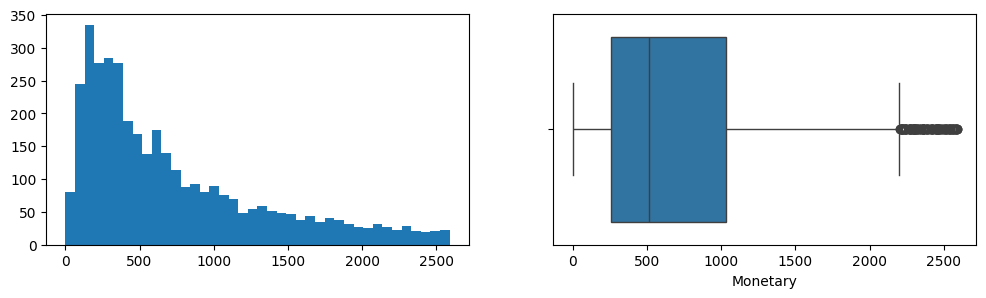

skewness: 1.3860975958728499


<Figure size 1200x300 with 0 Axes>

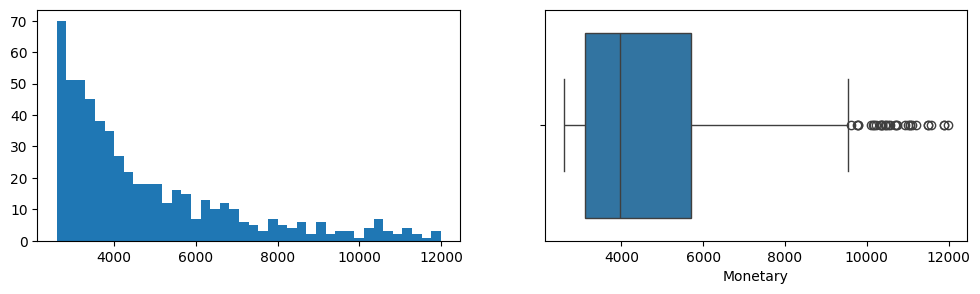

skewness: 1.3239545470344


<Figure size 1200x300 with 0 Axes>

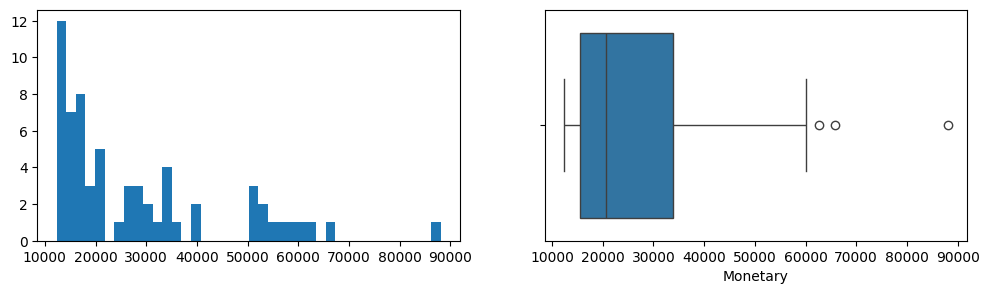

skewness: 0.3885617596971251


<Figure size 1200x300 with 0 Axes>

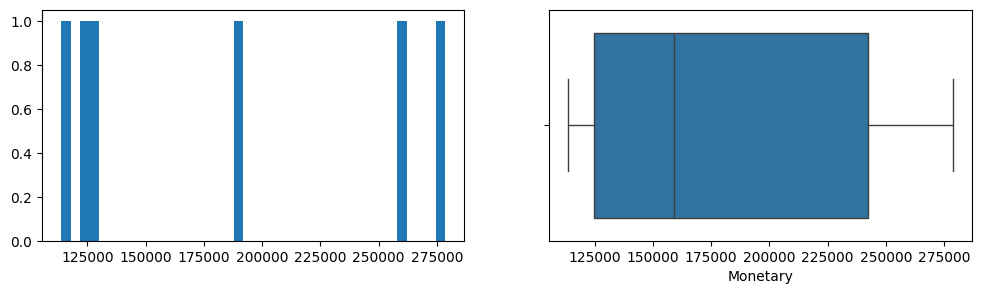

In [47]:
import matplotlib.gridspec as gridspec

for i in range(1,5):
    x = rfm_monetary[rfm_monetary['MonetaryScore'] == i]['Monetary']

    # Calculate the skewness 
    print(f'skewness: {skew(x, axis=0, bias=True)}')

    # Create 2x1 sub plots
    gs = gridspec.GridSpec(1, 2)

    # Create a figure
    plt.figure(figsize=(12,3))

    # add axes_1 row 0, col 0
    ax1 = plt.subplot(gs[0, 0]) 
    ax1 = plt.hist(x, bins=40)

    # add axes_2 row 0, col 1
    ax2 = plt.subplot(gs[0, 1]) 
    ax2 = sns.boxplot(data=x,orient='h')

    # display plot
    plt.show()

### 3.2.3. Recency Score

skewness: 1.2603365850994042


<Figure size 1200x600 with 0 Axes>

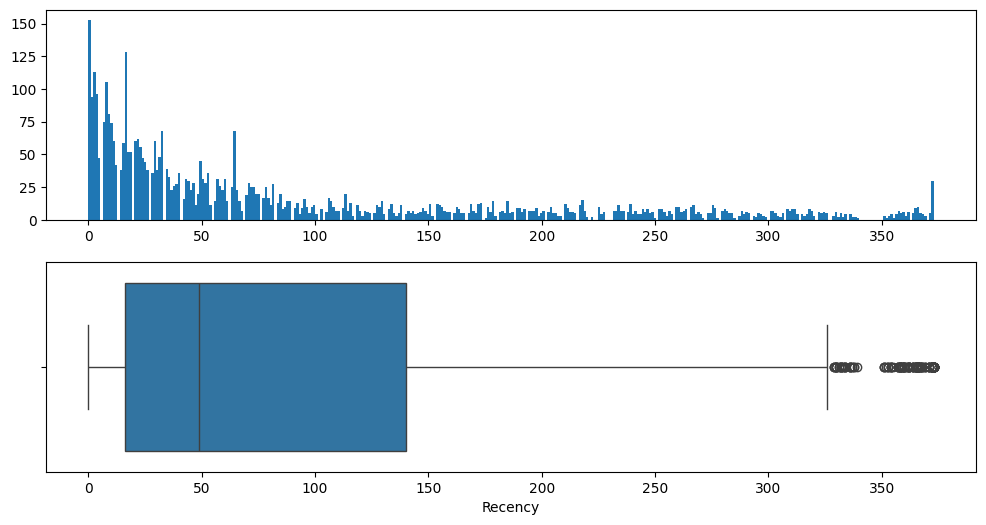

In [48]:
# Create 2x1 sub plots
gs = gridspec.GridSpec(2, 1)

x = processed_data['Recency']

# Calculate the skewness 
print(f'skewness: {skew(x, axis=0, bias=True)}')

# Create a figure
plt.figure(figsize=(12,6))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = plt.hist(x, bins=350)

# add axes_2 row 1, col 0
ax2 = plt.subplot(gs[1, 0]) 
ax2 = sns.boxplot(
    data=x
    ,orient='h'
)

# display plot
plt.show()

skewness: 0.3583917325333018


<Figure size 1200x300 with 0 Axes>

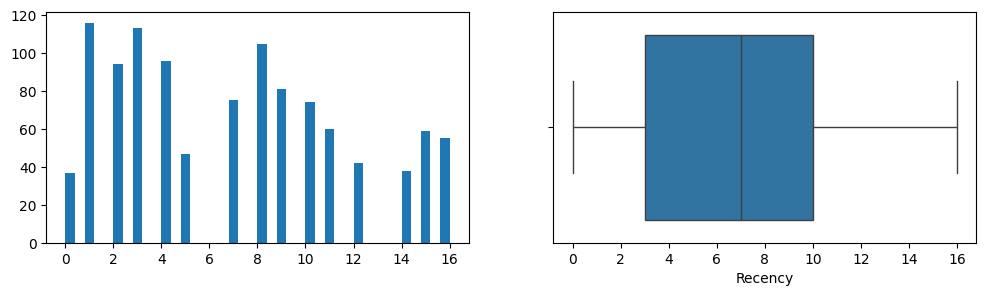

skewness: 0.39626642031680165


<Figure size 1200x300 with 0 Axes>

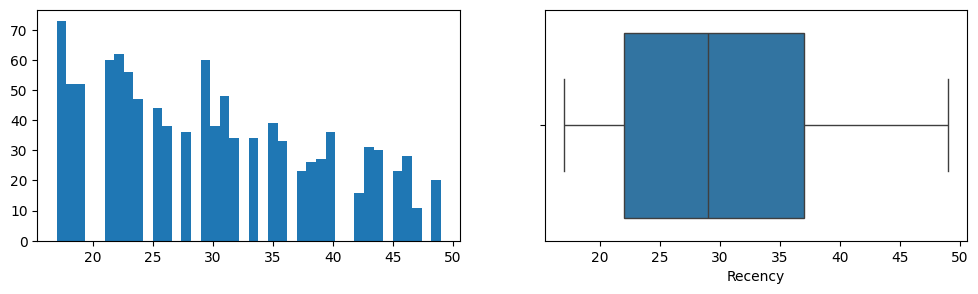

skewness: 0.6843695700996344


<Figure size 1200x300 with 0 Axes>

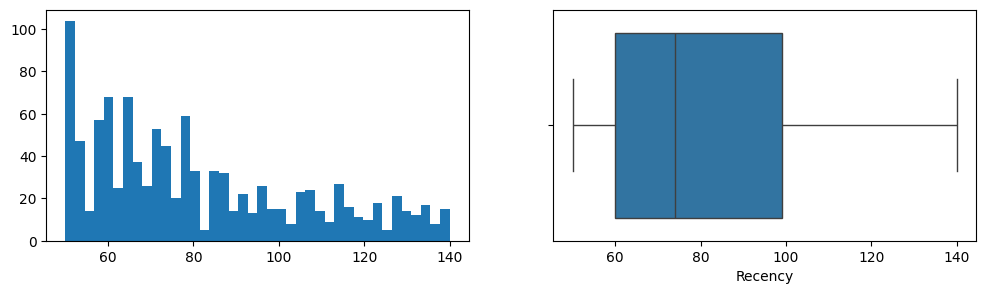

skewness: 0.31199419152492136


<Figure size 1200x300 with 0 Axes>

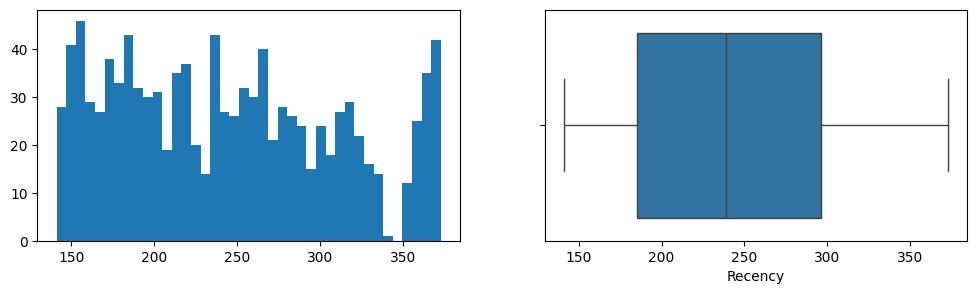

In [49]:
# Recency feature of the RFM model is the opposite of the Monetary feature since the more recent the transaction, the higher the Recency value, therefore we need to reverse the Recency values
processed_data["RecencyScore"] = pd.qcut(processed_data["Recency"], 4, labels = [4, 3, 2, 1])

for i in [4, 3, 2, 1]:
    x = processed_data[processed_data['RecencyScore'] == i]['Recency']

    # Calculate the skewness 
    print(f'skewness: {skew(x, axis=0, bias=True)}')

    # Create 2x1 sub plots
    gs = gridspec.GridSpec(1, 2)

    # Create a figure
    plt.figure(figsize=(12,3))

    # add axes_1 row 0, col 0
    ax1 = plt.subplot(gs[0, 0]) 
    ax1 = plt.hist(x, bins=40)

    # add axes_2 row 0, col 1
    ax2 = plt.subplot(gs[0, 1]) 
    ax2 = sns.boxplot(data=x,orient='h')

    # display plot
    plt.show()

# IV. RFM Score & RFM Segment

In [50]:
# Merge the RFM features into the processed data to create the RFM date with all the scores
scored_data = processed_data.merge(rfm_frequency[['FrequencyScore']], on='CustomerID', how='left').merge(rfm_monetary[['MonetaryScore']], on='CustomerID', how='left')
scored_data.head()


,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
CustomerID,,,,,,
12347,2,7,4310.00,4,1,2
12348,75,4,1437.24,2,1,1
12349,18,1,1457.55,3,1,1
12350,310,1,294.40,1,1,1
12352,36,7,1265.41,3,1,1


In [51]:
scored_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12347 to 18287
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Recency         4332 non-null   int64   
 1   Frequency       4332 non-null   int32   
 2   Monetary        4332 non-null   float64 
 3   RecencyScore    4332 non-null   category
 4   FrequencyScore  4332 non-null   int64   
 5   MonetaryScore   4332 non-null   int64   
dtypes: category(1), float64(1), int32(1), int64(3)
memory usage: 190.6+ KB


In [52]:
# RFMSegment feature is created by concatenating the RecencyScore, FrequencyScore and MonetaryScore columns
scored_data["RFMSegment"] = (
    scored_data['RecencyScore'].astype(str) + 
    scored_data['FrequencyScore'].astype(str) + 
    scored_data['MonetaryScore'].astype(str)
)

# RFMScore feature is calculated by summing the RecencyScore, FrequencyScore and MonetaryScore columns
scored_data["RFMScore"] = scored_data[['RecencyScore','FrequencyScore','MonetaryScore']].sum(axis=1)
scored_data.head()
print(f'an RFM segment based from three different RFM values has {scored_data["RFMSegment"].nunique()} unique values')
print(f'RFM score that sums up the RFM values and indicates a relative customer value has {scored_data["RFMScore"].nunique()} unique values ranging from {scored_data["RFMScore"].min()} to {scored_data["RFMScore"].max()}')

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMSegment,RFMScore
CustomerID,,,,,,,,
12347,2,7,4310.00,4,1,2,412,7
12348,75,4,1437.24,2,1,1,211,4
12349,18,1,1457.55,3,1,1,311,5
12350,310,1,294.40,1,1,1,111,3
12352,36,7,1265.41,3,1,1,311,5


an RFM segment based from three different RFM values has 30 unique values
RFM score that sums up the RFM values and indicates a relative customer value has 10 unique values ranging from 3 to 12


# V. Top 10 largest RFM segments

In [53]:
# top 10 largest RFM segments
scored_data['RFMSegment'].value_counts()[:10]

RFMSegment
111    1057
211     994
311     890
411     659
422     201
412     108
312      82
322      71
212      68
421      57
Name: count, dtype: int64

# VI. Customer Segmentation

## 6.2. Segmentation by RFMSegment

### Breakdown of the Segments


1. Champions
- Recency: 4 (most recent)
- Frequency: 4 (most frequent)
- Monetary: 4 (highest spender)
- These are your best customers — they buy frequently, spend a lot, and have purchased recently.

2. Runner-ups
- Recency: 3 or 4
- Frequency: 3 or 4
- Monetary: 4
- These customers buy often and spend a lot, but they may not have bought as recently or frequently as the "Champions"

3. Loyal Customers
- Recency: 3 or 4
- Frequency: 3 or 4
- Monetary: 1 or 2 
- Loyal customers are those who buy frequently and recently, but they may not always spend as much as "Champions" or "Runner-ups". Including "433","443" Segment

4. Can't Lose Them
- Recency: 4
- Frequency: 2 or 3
- Monetary: 3 or 4
- These customers have purchased recently but may not be as frequent or high-spending. They’re valuable and need to be nurtured. Including "324" Segment

5. Potential Loyalists
- Recency: 4
- Frequency: 2 or 3
- Monetary: 2 or 3
- These customers have made a recent purchase but may not have bought frequently or spent much. They show promise and could be turned into loyal customers with the right strategy.

6. Promising
- Recency: 3
- Frequency: 2 or 3
- Monetary: 3
- These customers may not be your top spenders or most frequent buyers yet, but they’ve shown interest and could develop into high-value customers over time.

7. New Customers
- Recency: 4
- Frequency: 1 or 2
- Monetary: 1 or 2
- These are recent customers who haven’t purchased frequently or spent a lot yet. They are still in the early stages of the customer lifecycle and need nurturing to increase their loyalty.

8. Needs Attention
- Recency: 2 or 3
- Frequency: 1 or 2
- Monetary: 1 or 3
- These customers used to buy but have become less frequent. You need to re-engage them with targeted promotions or reminders before they churn.

9. About to Sleep
- Recency: 1 or 2
- Frequency: 1 or 2
- Monetary: 3 or 4
- These customers haven’t bought in a while but were high spenders in the past. They need a re-engagement strategy to revive their interest.

10. Hibernating
- Recency: 1
- Frequency: 1 or 3
- Monetary: 1 or 3
- These customers haven’t purchased in a long time and don’t spend much. They are not completely lost, but they are dormant and require strong efforts to bring them back.

11. Lost Customer
- Recency: 1 (least recent)
- Frequency: 1 (least frequent)
- Monetary: 1 or 2 (lowest spender)
- These customers have not purchased for a long time, never buy much, and are at risk of being completely lost. If they haven't responded to previous attempts at engagement, they might be considered for exclusion from future marketing campaigns.

In [54]:
print('Summary Table of Segments Based on 4-Rank RFM')
pd.DataFrame({
    'Segment':[
        'New Customers'
        ,'Champions'
        ,'Runner-ups'
        ,'Loyal Customers'
        ,'Promising'
        ,'Can\'t Lose Them'
        ,'Potential Loyalists'
        ,'Needs Attention'
        ,'About to Sleep'
        ,'Hibernating'
        ,'Lost Customer'
    ]
    ,'Recency':[
        '4'
        ,'4'
        ,'3 or 4'
        ,'3 or 4'
        ,'3'
        ,'3 or 4'
        ,'4'
        ,'2 or 3'
        ,'1 or 2'
        ,'1'
        ,'1'
    ]
    ,'Frequency':[
        '1 or 2'
        ,'4'
        ,'3 or 4'
        ,'3 or 4'
        ,'2 or 3'
        ,'2 or 3'
        ,'2 or 3'
        ,'1 or 2'
        ,'1 or 2'
        ,'1 to 3'
        ,'1'
    ]
    ,'Monetary':[
        '1 or 2'
        ,'4'
        ,'4'
        ,'1 or 2'
        ,'3'
        ,'3 or 4'
        ,'2 or 3'
        ,'1 to 3'
        ,'3 or 4'
        ,'1 to 3'
        ,'1 or 2'
    ]
    ,'RFM Description':[
        'Recent customers, need nurturing'
        ,'Best customers; frequent, recent, and high spenders'
        ,'Recent, high spenders but less frequent'
        ,'Frequent buyers with average spending'
        ,'Moderate engagement; future potential'
        ,'Recent buyers but need nurturing'
        ,'Recent buyers with potential'
        ,'Inactive customers, need re-engagement'
        ,'High spenders, but dormant for a while'
        ,'Long-term inactive, low engagement, spenders'
        ,'Long-term inactive, low spenders'
    ]
})

Summary Table of Segments Based on 4-Rank RFM


,Segment,Recency,Frequency,Monetary,RFM Description
0,New Customers,4,1 or 2,1 or 2,"Recent customers, need nurturing"
1,Champions,4,4,4,"Best customers; frequent, recent, and high spenders"
2,Runner-ups,3 or 4,3 or 4,4,"Recent, high spenders but less frequent"
3,Loyal Customers,3 or 4,3 or 4,1 or 2,Frequent buyers with average spending
4,Promising,3,2 or 3,3,Moderate engagement; future potential
5,Can't Lose Them,3 or 4,2 or 3,3 or 4,Recent buyers but need nurturing
6,Potential Loyalists,4,2 or 3,2 or 3,Recent buyers with potential
7,Needs Attention,2 or 3,1 or 2,1 to 3,"Inactive customers, need re-engagement"
8,About to Sleep,1 or 2,1 or 2,3 or 4,"High spenders, but dormant for a while"
9,Hibernating,1,1 to 3,1 to 3,"Long-term inactive, low engagement, spenders"


In [55]:
# logic for RFM segmentation
seg_map = {
    r'444': 'Champions',
    r'[3-4][3-4]4': 'Runner-ups',
    r'[3-4][3-4][1-2]': 'Loyal Customers',
    r'443': 'Loyal Customers',
    r'433': 'Loyal Customers',
    r'4[2-3]4': 'Can\'t Lose Them',
    r'324': 'Can\'t Lose Them',
    r'4[2-3][2-3]': 'Potential Loyalists',
    r'4[1-2][1-2]': 'New Customers',
    r'3[2-3]3': 'Promising',
    r'[2-3][1-2][1-3]': 'Needs Attention',
    r'[1-2][1-2][3-4]': 'About to Sleep',
    r'11[1-2]': 'Lost Customers',
    r'1[1-3][1-3]': 'Hibernating',
    r'413': 'New Customers'
}

In [56]:
# Create a new column for the segment
scored_data['Segment'] = scored_data['RFMSegment'].replace(seg_map, regex=True)
scored_data.head()
scored_data.tail()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMSegment,RFMScore,Segment
CustomerID,,,,,,,,,
12347,2,7,4310.00,4,1,2,412,7,New Customers
12348,75,4,1437.24,2,1,1,211,4,Needs Attention
12349,18,1,1457.55,3,1,1,311,5,Needs Attention
12350,310,1,294.40,1,1,1,111,3,Lost Customers
12352,36,7,1265.41,3,1,1,311,5,Needs Attention


,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMSegment,RFMScore,Segment
CustomerID,,,,,,,,,
18280,277,1,180.60,1,1,1,111,3,Lost Customers
18281,180,1,80.82,1,1,1,111,3,Lost Customers
18282,7,2,176.60,4,1,1,411,6,New Customers
18283,3,16,2039.58,4,2,1,421,7,New Customers
18287,42,3,1837.28,3,1,1,311,5,Needs Attention


In [57]:
scored_data['Segment'].value_counts().sort_values(ascending=True)

Segment
Can't Lose Them           1
Champions                 1
About to Sleep            2
Runner-ups                4
Promising                 7
Hibernating               8
Loyal Customers          28
Potential Loyalists     233
New Customers           827
Lost Customers         1070
Needs Attention        2151
Name: count, dtype: int64

In [58]:
scored_data.groupby(['Segment'])['RFMSegment'].value_counts()

Segment              RFMSegment
About to Sleep       113              2
Can't Lose Them      324              1
Champions            444              1
Hibernating          122              4
                     121              3
                     132              1
Lost Customers       111           1057
                     112             13
Loyal Customers      433             17
                     432              8
                     443              2
                     331              1
Needs Attention      211            994
                     311            890
                     312             82
                     322             71
                     212             68
                     321             24
                     222             11
                     221             10
                     313              1
New Customers        411            659
                     412            108
                     421             57
        

In [112]:
scored_data.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMSegment,RFMScore,Segment
CustomerID,,,,,,,,,
12347,2,7,4310.00,4,1,2,412,7,New Customers
12348,75,4,1437.24,2,1,1,211,4,Needs Attention
12349,18,1,1457.55,3,1,1,311,5,Needs Attention
12350,310,1,294.40,1,1,1,111,3,Lost Customers
12352,36,7,1265.41,3,1,1,311,5,Needs Attention


In [122]:
# display full outputs in Jupyter Notebook, not only the last command's output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

agg_segment = scored_data.reset_index().groupby('Segment').agg({
    'Recency': 'mean'
    ,'Frequency': 'mean'
    ,'Monetary': 'mean'
    ,'CustomerID':'count'
}).reset_index()

agg_segment['Proportion'] = round(agg_segment['CustomerID'] * 100 / scored_data.shape[0],2)
agg_segment.drop(columns='CustomerID',inplace=True)
agg_segment

,Segment,Recency,Frequency,Monetary,Proportion
0,About to Sleep,208.500000,3.000000,30577.700000,0.05
1,Can't Lose Them,24.000000,20.000000,123638.180000,0.02
2,Champions,1.000000,198.000000,128333.730000,0.02
3,Hibernating,191.750000,13.250000,3494.618750,0.18
4,Lost Customers,244.509346,1.530841,459.270524,24.70
5,Loyal Customers,2.857143,57.821429,26025.501071,0.65
6,Needs Attention,55.686192,3.247792,1179.413753,49.65
7,New Customers,7.487304,4.378476,1476.182092,19.09
8,Potential Loyalists,5.523605,16.236052,8167.465708,5.38
9,Promising,28.142857,26.285714,29187.104286,0.16


## 6.3. Visualizing RFM Segments

### 6.3.1. 3D Scatter Plot

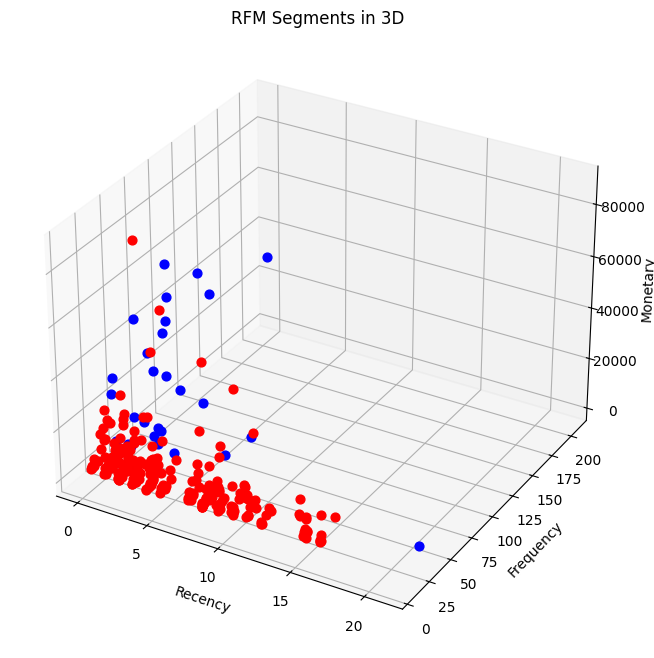

In [66]:
# display the last command's output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

# Assuming your RFM data is in a dataframe `x`
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
condition = scored_data['Segment'].isin(['Potential Loyalists','Loyal Customers'])
data = scored_data[condition]
data['Colors'] = data['Segment'].apply(lambda x: 'red' if x == 'Potential Loyalists' else 'blue')

 
for x, y, z, c, l in zip(data.Recency, data.Frequency, data.Monetary, data.Colors, data.Segment):
    ax.scatter(xs=x, ys=y, zs=z, s=40, c=c, label=l)

# ax.legend(ncol=1)
plt.grid(b=True)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('RFM Segments in 3D')
plt.show()

### 6.3.2. 2D Bubble Chart

In [79]:
hover_text = []
for index, row in agg_segment.iterrows():
    hover_text.append(
        (
            'Segment: {Segment}<br>'+
            'Monetary: {Monetary}<br>'
        ).format(Segment=row['Segment'],Monetary=row['Monetary'])
    )

hover_text

['Segment: About to Sleep<br>Monetary: 30577.7<br>',
 "Segment: Can't Lose Them<br>Monetary: 123638.18000000001<br>",
 'Segment: Champions<br>Monetary: 128333.73<br>',
 'Segment: Hibernating<br>Monetary: 3494.61875<br>',
 'Segment: Lost Customers<br>Monetary: 459.2705242990654<br>',
 'Segment: Loyal Customers<br>Monetary: 26025.50107142857<br>',
 'Segment: Needs Attention<br>Monetary: 1179.4137526731752<br>',
 'Segment: New Customers<br>Monetary: 1476.182091898428<br>',
 'Segment: Potential Loyalists<br>Monetary: 8167.4657081545065<br>',
 'Segment: Promising<br>Monetary: 29187.104285714282<br>',
 'Segment: Runner-ups<br>Monetary: 210353.22999999998<br>']

In [108]:
agg_segment['text'] = hover_text
agg_segment['color'] = [
    '#9e0142'
    ,'#d53e4f'
    ,'#f46d43'
    ,'#fdae61'
    ,'#7c6523'
    ,'#000000'
    ,'#3b4507'
    ,'#abdda4'
    ,'#66c2a5'
    ,'#3288bd'
    ,'#beb0ff'
]

In [109]:
# fig = go.Figure()

# for index,row in agg_segment.iterrows():
#     fig.add_trace(go.Scatter(
#         x=row['Recency']
#         , y=row['Frequency']
#         , name=row['Segment']
#         , text=row['text']
#         , marker_size=row['Monetary']
#         ))
    
# fig.show()

In [111]:
fig = go.Figure(
    data=[
        go.Scatter(       
            x=agg_segment['Recency'],
            y=agg_segment['Frequency'],
            mode='markers',
            marker=dict(
                size=agg_segment['Monetary'],
                sizemode='area',
                sizeref=2.*max(agg_segment['Monetary'])/(40.**2),
                sizemin=4,
                color=agg_segment['color']
            ),
            text=agg_segment['text']
        )
    ]
)

fig.update_layout(
    title=dict(text='Customer Segmentation by Average RFM Features, Size by Monetary'),
    xaxis=dict(title=dict(text='Recency')),
    yaxis=dict(title=dict(text='Frequency')),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)'
)


## 6.4. Comparing Features of each segmentation

,Segment,Recency,Frequency,Monetary
0,About to Sleep,208.500000,3.000000,30577.700000
1,Can't Lose Them,24.000000,20.000000,123638.180000
2,Champions,1.000000,198.000000,128333.730000
3,Hibernating,191.750000,13.250000,3494.618750
4,Lost Customers,244.509346,1.530841,459.270524
5,Loyal Customers,2.857143,57.821429,26025.501071
6,Needs Attention,55.686192,3.247792,1179.413753
7,New Customers,7.487304,4.378476,1476.182092
8,Potential Loyalists,5.523605,16.236052,8167.465708
9,Promising,28.142857,26.285714,29187.104286


<Figure size 1200x600 with 0 Axes>

C:\Users\Hung\AppData\Local\Temp\ipykernel_10264\3609500118.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ).set_xticklabels(labels=agg_segment.sort_values('Monetary')['Segment'],rotation=45)


[Text(0, 0, 'Lost Customers'),
 Text(1, 0, 'Needs Attention'),
 Text(2, 0, 'New Customers'),
 Text(3, 0, 'Hibernating'),
 Text(4, 0, 'Potential Loyalists'),
 Text(5, 0, 'Loyal Customers'),
 Text(6, 0, 'Promising'),
 Text(7, 0, 'About to Sleep'),
 Text(8, 0, "Can't Lose Them"),
 Text(9, 0, 'Champions'),
 Text(10, 0, 'Runner-ups')]

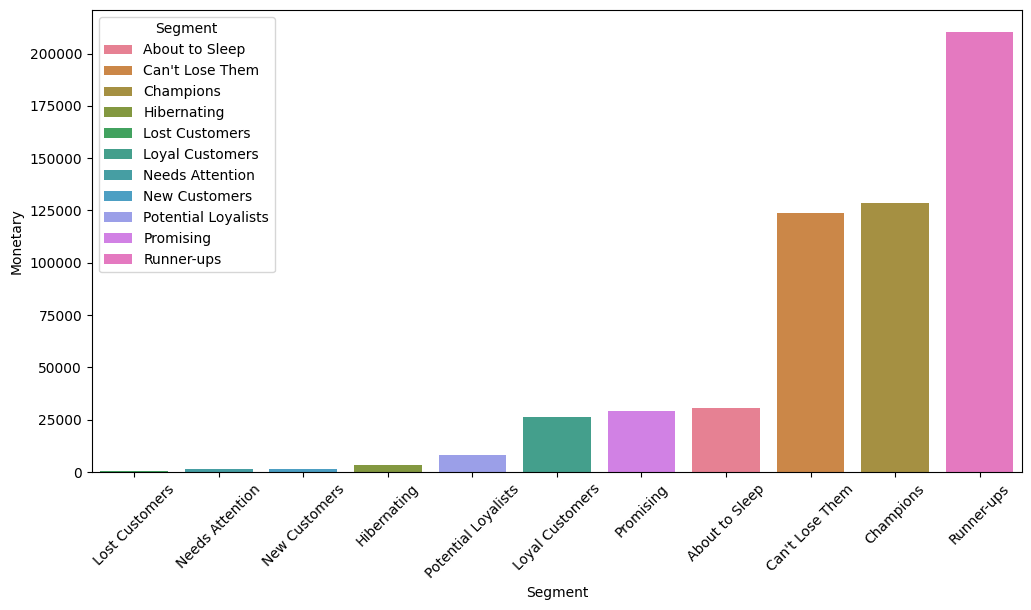

In [61]:
# compare the segments with the monetary value
plt.figure(figsize=(12,6))
sns.barplot(
    data=agg_segment
    ,x='Segment'
    ,y='Monetary'
    ,hue='Segment'
    ,order=agg_segment.sort_values('Monetary')['Segment']
    ,legend=True
).set_xticklabels(labels=agg_segment.sort_values('Monetary')['Segment'],rotation=45)


<Figure size 1200x600 with 0 Axes>

C:\Users\Hung\AppData\Local\Temp\ipykernel_10264\326068735.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ).set_xticklabels(labels=agg_segment.sort_values('Frequency')['Segment'],rotation=45)


[Text(0, 0, 'Lost Customers'),
 Text(1, 0, 'About to Sleep'),
 Text(2, 0, 'Needs Attention'),
 Text(3, 0, 'New Customers'),
 Text(4, 0, 'Hibernating'),
 Text(5, 0, 'Potential Loyalists'),
 Text(6, 0, "Can't Lose Them"),
 Text(7, 0, 'Promising'),
 Text(8, 0, 'Loyal Customers'),
 Text(9, 0, 'Runner-ups'),
 Text(10, 0, 'Champions')]

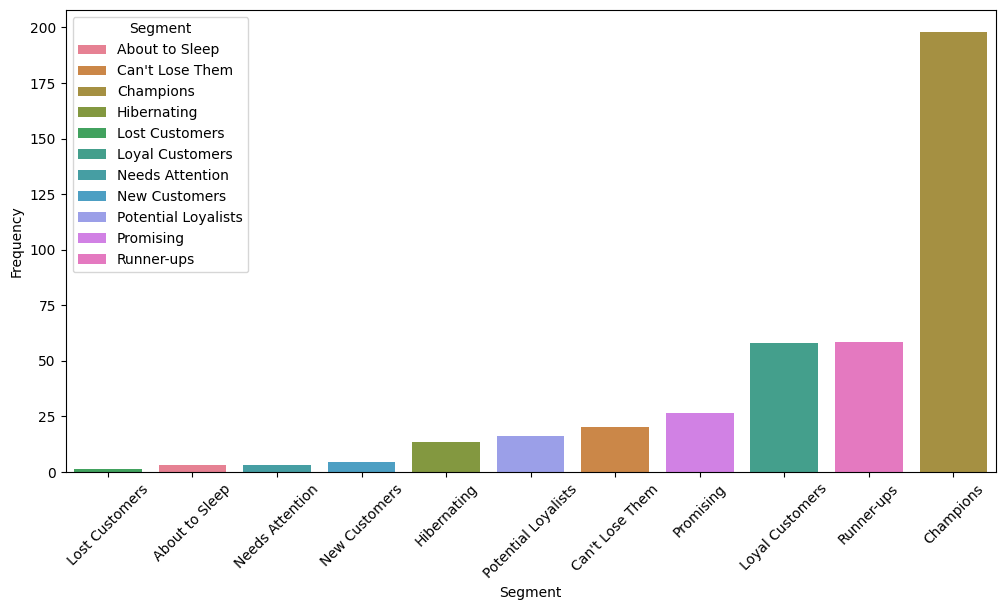

In [62]:
# compare the segments with the frequency value
plt.figure(figsize=(12,6))
sns.barplot(
    data=agg_segment
    ,x='Segment'
    ,y='Frequency'
    ,hue='Segment'
    ,order=agg_segment.sort_values('Frequency')['Segment']
    ,legend=True
).set_xticklabels(labels=agg_segment.sort_values('Frequency')['Segment'],rotation=45)

<Figure size 1200x600 with 0 Axes>

C:\Users\Hung\AppData\Local\Temp\ipykernel_10264\143744218.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ).set_xticklabels(labels=agg_segment.sort_values('Recency')['Segment'],rotation=45)


[Text(0, 0, 'Champions'),
 Text(1, 0, 'Loyal Customers'),
 Text(2, 0, 'Runner-ups'),
 Text(3, 0, 'Potential Loyalists'),
 Text(4, 0, 'New Customers'),
 Text(5, 0, "Can't Lose Them"),
 Text(6, 0, 'Promising'),
 Text(7, 0, 'Needs Attention'),
 Text(8, 0, 'Hibernating'),
 Text(9, 0, 'About to Sleep'),
 Text(10, 0, 'Lost Customers')]

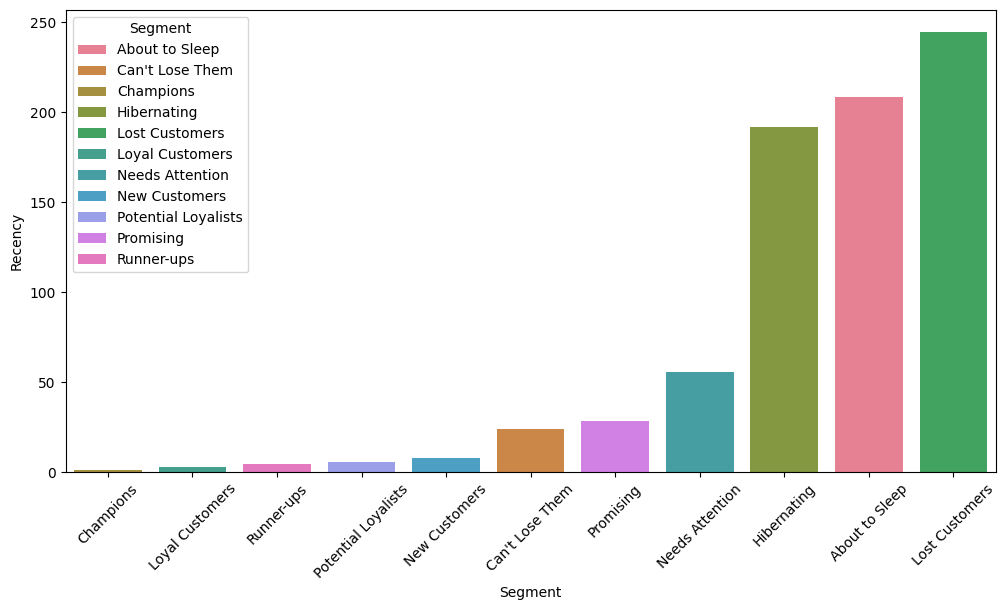

In [63]:
# compare the segments with the Recency value
plt.figure(figsize=(12,6))
sns.barplot(
    data=agg_segment
    ,x='Segment'
    ,y='Recency'
    ,hue='Segment'
    ,order=agg_segment.sort_values('Recency')['Segment']
    ,legend=True
).set_xticklabels(labels=agg_segment.sort_values('Recency')['Segment'],rotation=45)

# VII. Recommendations

## 7.1. Action Plans tailored for each segments

1. Champions (R5, F5, M5)
- Customer Profile: These are your best customers—frequent buyers who spend a lot and have purchased recently.
- Action Plan:
    + Reward loyalty: Offer exclusive loyalty programs, early access to new products, or VIP rewards.
    + Personalized offers: Send personalized messages and tailored discounts based on their past purchase behavior.
    + Referral programs: Encourage these customers to refer others by offering them incentives or rewards for successful referrals.
    + Surprise and delight: Send them thank-you gifts or special offers as a gesture of appreciation for their loyalty.
    + Content engagement: Continue to engage them through newsletters, social media, and special events.


2. Can’t Lose (R5, F4, M5)
- Customer Profile: These customers are recent and spend a lot, but may not purchase as frequently.
- Action Plan:
    + Increase frequency: Use targeted campaigns to increase purchase frequency. Offer time-limited discounts or reminders to encourage repeat purchases.
    + Reinforce loyalty: Send personalized loyalty offers to keep them engaged, such as exclusive discounts on their next purchase.
    + Leverage exclusivity: Offer access to members-only products or promotions that encourage a deeper connection.


3. Loyal Customers (R4, F4, M4)
- Customer Profile: These customers are regular, moderately high spenders, and still fairly recent.
- Action Plan:
    + Retention strategies: Focus on retention efforts such as personalized discounts, loyalty programs, and seasonal offers to keep them coming back.
    + Exclusive content: Provide access to exclusive content, sneak peeks of new arrivals, or early product releases.
    + Upsell and cross-sell: Use their purchase history to suggest complementary products or services to increase their overall spend.


4. Potential Loyalists (R5, F3, M4)
- Customer Profile: These customers have recently purchased and spent well, but their frequency needs improvement.
- Action Plan:
    + Encourage more purchases: Create special offers, incentives, or loyalty bonuses for making additional purchases within a given period.
    + Nurture the relationship: Continue to engage them through newsletters, exclusive offers, or product recommendations based on their initial purchase.
    + Feedback request: Ask them for feedback to improve your product offerings and make them feel valued.


5. Promising (R4, F3, M5)
- Customer Profile: These customers spend well but aren't as recent or frequent.
- Action Plan:
    + Re-engage: Use targeted email campaigns to bring them back with promotions like discounts or reminders.
    + Encourage frequency: Offer a time-sensitive incentive to increase the frequency of their next purchase.
    + Personalized offers: Create targeted offers that appeal to their past purchasing habits and preferences.


6. At Risk (R1, F3, M5)
- Customer Profile: Customers who have spent well in the past but have not made a recent purchase.
- Action Plan:
    + Win-back campaigns: Offer exclusive deals, discounts, or incentives to bring them back.
    + Re-engagement emails: Use compelling subject lines to remind them of your brand and their last positive experience.
    + Personalized messaging: Reach out with personalized messages and address any potential issues with their past experience to entice them back.


7. New Customers (R5, F1, M2)
- Customer Profile: These customers have just made a purchase but are infrequent and low spenders.
- Action Plan:
    + Welcome series: Send a welcome email series to introduce them to your brand and make them aware of your loyalty programs and discounts.
    + Incentivize repeat purchases: Offer them a discount on their next purchase or other promotions to encourage them to make another purchase.
    + Personalize engagement: Continue engaging them with product recommendations based on their initial purchase and highlight your best-selling or most relevant items.


8. About to Sleep (R1, F2, M3)
- Customer Profile: These customers have been inactive for some time and don't purchase frequently, with moderate spending.
- Action Plan:
    + Re-engagement efforts: Send them special offers or reminder emails with a focus on their past purchase behavior.
    + Incentivize: Offer incentives to encourage their return, such as discounts or exclusive access to new products.
    + Survey them: Ask for feedback to understand why they stopped purchasing and address any concerns they may have.


9. Need Attention (R2, F1, M4)
- Customer Profile: Customers who are infrequent and not very recent, but they spend moderately.
- Action Plan:
    + Personalized outreach: Reach out to them with special offers that encourage them to return, such as a personalized discount or exclusive offers.
    + Re-engagement emails: Send them emails tailored to their past behavior, reminding them of the value your brand can offer.
    + Promotions: Offer a limited-time offer or flash sales to increase the urgency for them to make a purchase.


10. Hibernating (R1, F1, M1)
- Customer Profile: Customers who have been inactive for a long time, rarely purchase, and spend very little.
- Action Plan:
    + Re-engagement campaigns: Implement a re-engagement campaign with a strong incentive, like deep discounts or exclusive deals.
    + Targeted outreach: Send them personalized emails or even try direct mail if your brand has a strong offline presence.
    + VIP reactivation: Offer something highly personalized to get their attention and show that you value them as a customer.


## Update
Actions Based on Segments:
Champions: Reward them with loyalty programs, exclusive offers, and personalized engagement.
Runner-ups: Use targeted promotions to increase frequency or maintain loyalty.
Loyal Customers: Offer incentives for continued engagement, like discounts for repeat purchases.
Can't Lose Them: Retarget with special offers, reminders, or loyalty bonuses to ensure they stay engaged.
Potential Loyalists: Provide incentives to convert them into regular customers (e.g., discounts, loyalty programs).
Promising: Introduce cross-selling or upselling strategies to increase their overall value.
New Customers: Nurture with welcome offers and build a relationship to convert them into loyal buyers.
Needs Attention: Use re-engagement campaigns, such as time-limited offers or discounts.
About to Sleep: Re-engage with personalized offers or reminders about their previous high spending.
Hibernating: Consider re-engagement campaigns or remove them from your active marketing.
Lost Customers: Target them with win-back campaigns or exclude from future marketing efforts.

## 7.2. Performance Monitor Metrics

- Customer Retention Rate: Measure how well each segment is retained after specific campaigns.
- Conversion Rate: Track how many customers in each segment convert based on targeted offers.
- Customer Lifetime Value (CLV): Monitor changes in CLV after executing specific segment strategies.
- Revenue per Customer: Calculate the increase in revenue per customer per segment after targeted marketing.

# VIII. Additional Resources

Interesting theory about how to choose scale from your dataset size: https://www.omniconvert.com/blog/rfm-segmentation-guide/#:~:text=RFM%20segmentation%20is%20a%20method,customer%20loyalty%20and%20lifetime%20value.